# Solving Heat Equation PDE by using Fourier Transform
One of the many ways for solving PDE's, which are usually extremely difficult (if possible at all), is to use certain tools in order to transform it into an ODE, much easier to solve. This is what we are presenting here, an easy-to-follow guide on how to use Fourier Transform to solve the 1-D Heat Equation. This equation is represented by:

$$\Large \frac{\partial U}{\partial t} = {c^2}\frac{\partial^2 U}{\partial x^2}$$

Where U is the Temperature function U(x,t).

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [14, 14]
plt.rcParams.update({'font.size': 20})

In [147]:
c = 2 #Thermal Diffusivity
L = 100 #Lenght of the hipotetical bar
N = 1000 #Points used to calculate our solution
dx = L/N #Spatian interval
x = np.arange(-L/2, L/2, dx) #Defining discrete domain vector

The useful property of the Fourier Transform that helps solving PDE's is that the transform of a derivative in the Fourier Domain is the original function (in the Fourier Domain) multiplied by the imagine part "i" and a constant K (called Kappa), similar to an eigenvector problem (which it pretty much is after the transformation). In mathematical terms: 

$$\Large \mathscr{F}\{\frac{\partial U}{\partial x}\}= {iK } \hat{u}(\hat{x},t)$$

Differenciating again, we get the result for the second derivative:

$$\Large \mathscr{F}\{\frac{\partial^2 U}{\partial x^2}\}= {-K^2 } \hat{u}(\hat{x},t)$$

So the plan is to take the Fourier Transform on both sides of the equation, end up with an ODE in the Fourier domain and solve with a regular integrator. Quick note here, that Fourier Domain means that instead of spacial domain we now have a frequency domain, called "Spatial Frequency". After solving this ODE, we just perform the Inverse Fourier Transform on the solution vector and we are done with the final solution in the original domain.

In [148]:
#Defining Kappa vecotr
kappa = 2*np.pi*np.fft.fftfreq(N,d=dx)

In [149]:
#Defining Initial Temperature Distribution (a hat function)
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

Before continuing with the solving, SciPy's odeint integrator cannot handle properly complex numbers, so we have to do a little trick here and transform the u0hat N-elements complex vector into  a 2N-elements real vector. We will be going back-and-forth with this form, because it needs to be real-only to be properly computed by our integrator, but it must be in the complex form for the inverse Fourier transform work properly. Note here, in Python the imaginary unit i is denoted by j.

In [150]:
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

In [151]:
#Preparing the time interval and time steps:
dt = 0.1
t = np.arange(0,10,dt)

Now we will define a function to return the temporal derivative of U function, which is the right-hand side of the equation. This function will be the input argument to our odeint integrator to be solved. 

In [152]:
def rhsHeat(uhat_ri,t,kappa,c):
    #Transforming to a complex vector again
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    #Computing the derivative in its complex form
    d_uhat = -c**2 * (np.power(kappa,2)) * uhat
    #Transforming the derivative complex 1N-element
    #vector to a 2N-elements real vector
    du_hat_ri = np.concatenate((d_uhat.real,d_uhat.imag)).astype('float64')
    return du_hat_ri

Now we can finally call the integrator and solve the equation in Fourier Domain. The arguments to the solver are:
- right-hand side equation (in the form du/dt = f(x,y), this would represent the f function)
- initial conditions vector
- time to be computed
- optional arguments, such as constants

In [153]:
uhat_ri = odeint(rhsHeat, u0hat_ri, t, args=(kappa,c))

In [154]:
#Again, creating the complex N-elements vector
uhat = uhat_ri[:,:N] + (1j)*uhat_ri[:,N:]

After our equation is solved in Fourier Domain, we can now take this uhat solution vector and inverse Fourier transform it to obtain our solution in the spatial domain. Worth a notice here, we will have to take the inverse transform for each time step, since our solution is a vector u_hat $$\Large\hat{u}(\hat{x},t)$$ in the spatial frequency domain. Since the algorithm of the Fast Fourier Transform is so efficient, this takes very little time and allows a great level of accuracy.

In [155]:
u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k,:])

Because of numerical oscilations, there might be some small complex residues in our u vector, which should be real-only since we are now in spatial domain. Because of these residues, a good practice is to take only the real part of u and using it as the actual final solution.

In [156]:
u = u.real

Finally, we can plot our solution and see how our temperature varies with time. A great to visualize this is with what's called "Waterfall Plot", which is a 3D plot with the lenght, time and temperatue values. Since we began with a hat-function as our initial temperature distribution function, we should expect to see the edges getting smoother each time, causing the heat to become more and more gaussian-like. 
The code for this plot might seem a bit messy (just like every Python plot, or maybe every language plot tools) but is pretty strait-forward and can be easily followed by the documentation of the library. 

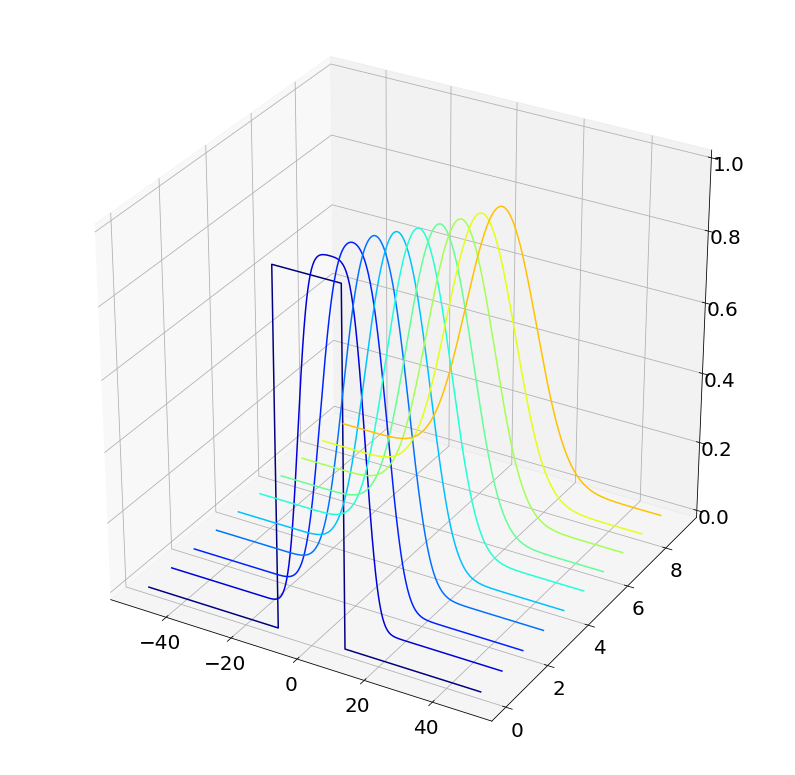

In [157]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plt.set_cmap('jet_r')
u_plot = u[0:-1:10,:]

for k in range(u_plot.shape[0]):
    ys = k*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[k,:],color=cm.jet(k*20))

Just as expected! The edges are the first part to be "smoothed", followed by the general lowering of the top point and rising up of the lateral points. By adjusting the values of the thermal diffusivity, we can control how fast this decay occurs.
Just for fun, let's try a different initial distribution, like a gaussian fucntion, which can be also represented (kind of) by a hyperbolic secant (1/cosh). 

In [164]:
#Defining Temperature Distribution (hyperbolic secant function)
u0_2 = np.zeros_like(x)

for i in range(len(x)):
    u0_2[i] = 1/np.cosh(x[i])

u0hat_2 = np.fft.fft(u0_2)

In [165]:
u0hat_ri_2 = np.concatenate((u0hat_2.real,u0hat_2.imag))

In [166]:
uhat_ri_2 = odeint(rhsHeat, u0hat_ri_2, t, args=(kappa,c))

In [168]:
uhat_2 = uhat_ri_2[:,:N] + (1j)*uhat_ri_2[:,N:]
u_2 = np.zeros_like(uhat_2)

for k in range(len(t)): 
    u_2[k,:] = np.fft.ifft(uhat_2[k,:])

    u_2 = u_2.real


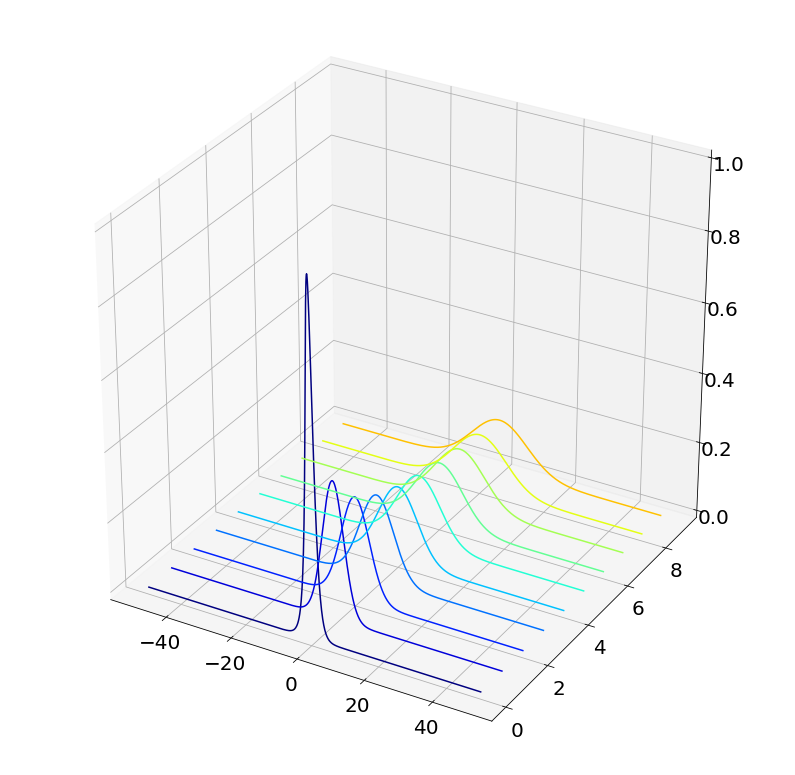

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plt.set_cmap('jet_r')
u_plot_2 = u_2[0:-1:10,:]

for k in range(u_plot_2.shape[0]):
    ys = k*np.ones(u_plot_2.shape[1])
    ax.plot(x,ys,u_plot_2[k,:],color=cm.jet(k*20))

It's also important to understand physically what's going on here. Since our initial temperature distribution is so narrow, it acts like one big edge, therefore having it's top temperature decaying very quickly. By making the distribution a bit more "regular" and reducing this sharp end, we should get a slower decay. Let's try to smooth this curve.

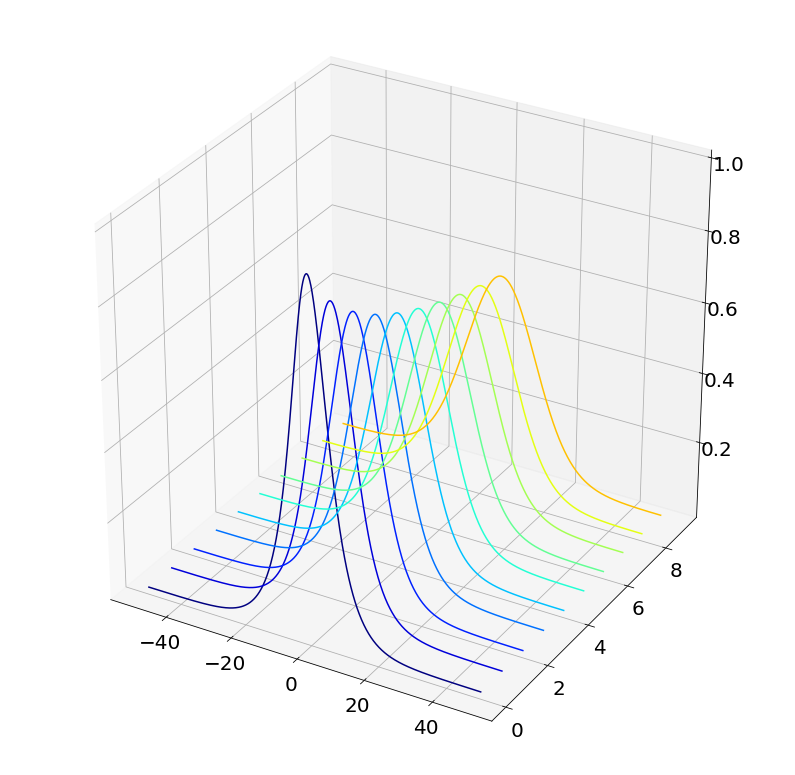

In [171]:
#Defining Initial conditions (hyperbolic secant function)
u0_3 = np.zeros_like(x)
for i in range(len(x)):
    u0_3[i] = 1/np.cosh(x[i]/5)
u0hat_3 = np.fft.fft(u0_3)

u0hat_ri_3 = np.concatenate((u0hat_3.real,u0hat_3.imag))

uhat_ri_3 = odeint(rhsHeat, u0hat_ri_3, t, args=(kappa,c))

uhat_3 = uhat_ri_3[:,:N] + (1j)*uhat_ri_3[:,N:]
u_3 = np.zeros_like(uhat_3)

for k in range(len(t)):
    u_3[k,:] = np.fft.ifft(uhat_3[k,:])

u_3 = u_3.real

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plt.set_cmap('jet_r')
u_plot_3 = u_3[0:-1:10,:]
for k in range(u_plot_3.shape[0]):
    ys = k*np.ones(u_plot_3.shape[1])
    ax.plot(x,ys,u_plot_3[k,:],color=cm.jet(k*20))

Again, just as we expected! Reducing the "narrowness" of the initial distribution, its decay occur much slower.
This was only one of the infinitely many uses of the Fourier Transform, and the accuracy achieved by this tool is amazing, combined with a surprisingly fast compute time. Although the heat equation is the one that originated Fourier Series and Fourier Transforms in the first place, it's use can be extended to many more PDE's, showing how powerful it is in an area that it's not commonly known for, like its use in image and audio compressing.